<h1 style="text-align:center; border-style: solid;border-width: 10px;border-color:#000080; border-radius:10px; padding:50px;background-color:DodgerBlue; color:white; font-size: 40px;font-family: 'Courier New', monospace;font-weight:800">Housing Price prediction using Linear regression</h1>

In [1]:
import numpy as np #Standard numerical operation
import pandas as pd #Dataframe import and manipulation

import datetime

#Plot library
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.api import OLS,add_constant #OLS model
from statsmodels.stats.outliers_influence import variance_inflation_factor #VIF to check multicollinearity

from sklearn.impute import KNNImputer #Imputing the null value 
from sklearn.model_selection import train_test_split #Split the dataset into train and test
from sklearn.linear_model import Lasso,LinearRegression #Linear model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #metrics for examining the model

# Setting plot theme and warning 
from matplotlib import warnings
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings("ignore") 

In [2]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv",index_col=0)
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv",index_col=0)

In [3]:
train.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

In [4]:
test.dtypes.value_counts()

object     43
int64      25
float64    11
dtype: int64

In [5]:
# Checking for null values in train and test set
null_value = pd.DataFrame()
null_value['variable'] = test.columns
null_value['Train'] = train.drop(labels='SalePrice',axis=1).isnull().sum().to_list()
null_value['Test']=test.isnull().sum().to_list()
null_value

,variable,Train,Test
0,MSSubClass,0,0
1,MSZoning,0,4
2,LotFrontage,259,227
3,LotArea,0,0
4,Street,0,0
...,...,...,...
74,MiscVal,0,0
75,MoSold,0,0
76,YrSold,0,0
77,SaleType,0,1


In [6]:
# Selecting the non-null variable in both training and testing Dataset
no_null_col = null_value[(null_value['Train']==0) & (null_value['Test']==0)].variable.to_list()

In [7]:
df_train = train[no_null_col]
df_train['SalePrice'] = train['SalePrice']
df_test = test[no_null_col]

In [8]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.0,50.0,70.00,190.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.0,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.0,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.0,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.0,1994.0,2004.00,2010.0
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.0,1087.0,1391.25,4692.0
2ndFlrSF,1460.0,346.992466,436.528436,0.0,0.0,0.0,728.00,2065.0
LowQualFinSF,1460.0,5.844521,48.623081,0.0,0.0,0.0,0.00,572.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0


In [9]:
# Code for ploting boxplot and distplot of feature
def plot_hist_box(data):
    figure, axis = plt.subplots(1,2,figsize=(15, 5))
    plt.suptitle(data.name)
    axis[0].boxplot(data)
    axis[1] = sns.distplot(data)
    axis[1].lines[0].set_color('crimson')
    rect = plt.Rectangle(
    (0, 0), 1, 1, fill=False, color="k", lw=3, transform=figure.transFigure, figure=figure)
    figure.patches.extend([rect])
    plt.show()

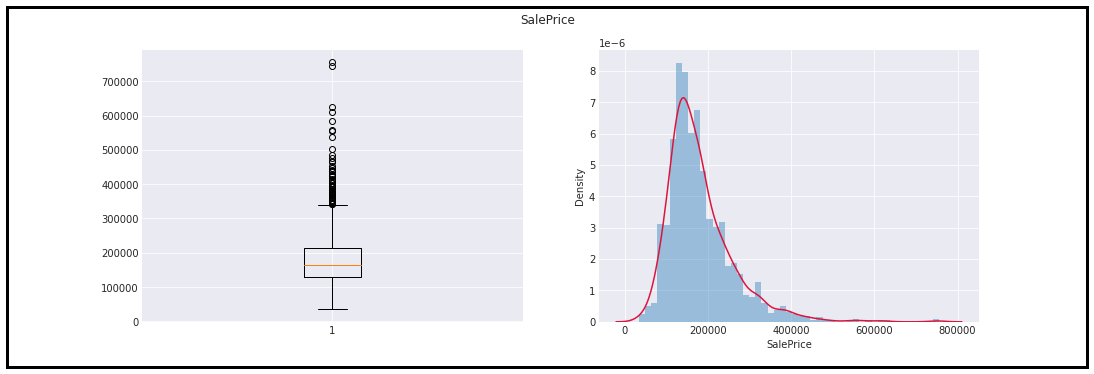

In [10]:
plot_hist_box(df_train.SalePrice)

**Insights**

- We have very few highly priced houses, most of the houses are in the range of 30000-400000

## Feature Engineering

We can get information of the age of house with the help of YrSold and YearBuilt

In [11]:
df_train['House_Age'] = df_train.YrSold - df_train.YearBuilt
df_train['RemodAge']  = df_train.YrSold - df_train.YearRemodAdd
df_train.drop(labels=['YrSold','YearBuilt','YearRemodAdd'],inplace=True,axis=1)

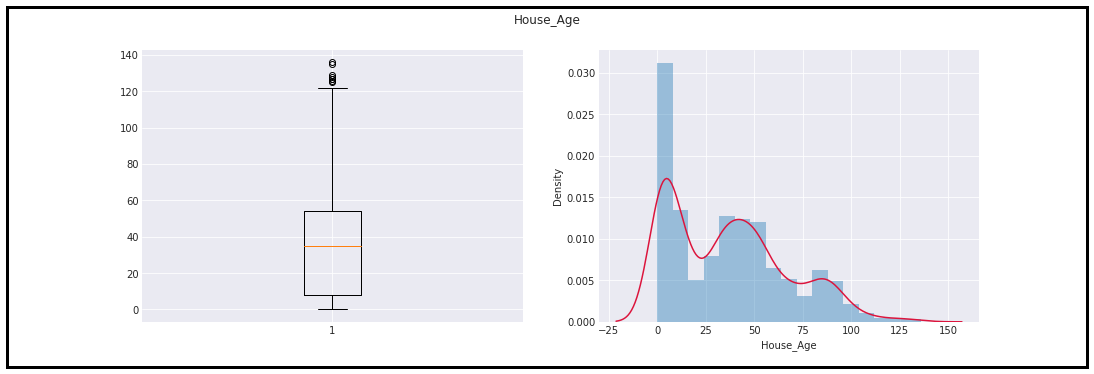

In [12]:
plot_hist_box(df_train.House_Age)

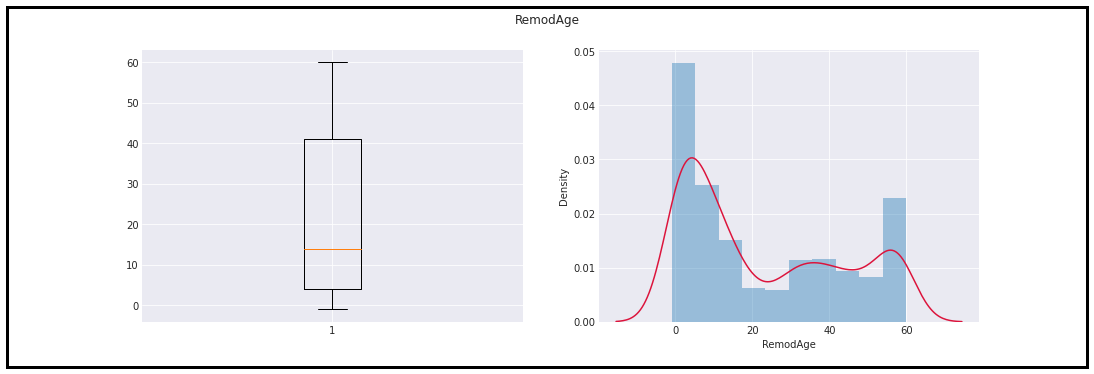

In [13]:
plot_hist_box(df_train.RemodAge)

In [14]:
df_test['House_Age'] = df_test.YrSold - df_test.YearBuilt
df_test['RemodAge']  = df_test.YrSold - df_test.YearRemodAdd
df_test.drop(labels=['YrSold','YearBuilt','YearRemodAdd'],inplace=True,axis=1)

In [15]:
# We have over all condition and over all Quality, averaging both can give us an overall rating
# This can be a very good, and will reduce the feature
df_train['Overall_Rating'] = (df_train.OverallCond + df_train.OverallQual)*0.5
df_test['Overall_Rating'] = (df_test.OverallCond + df_test.OverallQual)*0.5
df_train.drop(labels=['OverallQual','OverallCond'],inplace=True,axis=1)
df_test.drop(labels=['OverallQual','OverallCond'],inplace=True,axis=1)

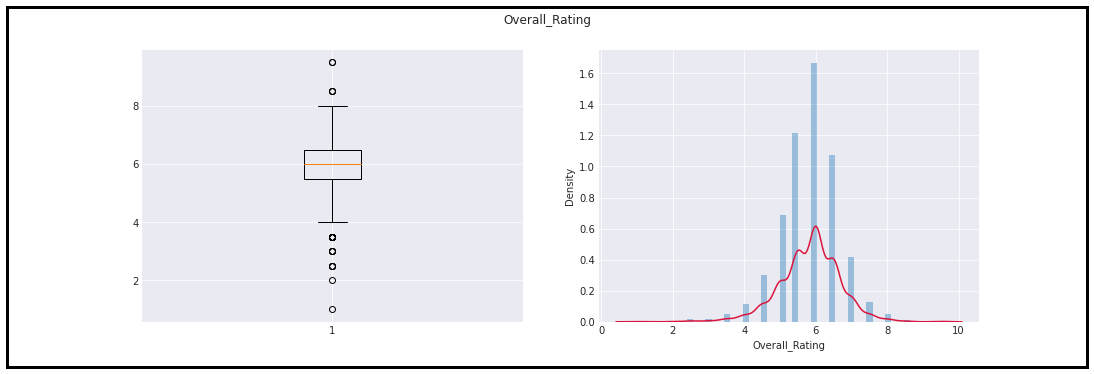

In [16]:
plot_hist_box(df_train.Overall_Rating)

In [17]:
# we have missing Value in LotFrontage but we know that it is very important feature as people are
# looking for the road attached building
# We can see if access to street is available or not by street variable
train.Street.isnull().sum() # 0; so we can clearly say that every building has access to street
# we can't impute LotFrontage with 0;

df_train['LotFrontage'] = train.LotFrontage
df_test['LotFrontage'] = test.LotFrontage

imputer = KNNImputer(n_neighbors=2)
df_train.LotFrontage = imputer.fit_transform(df_train[['LotFrontage']])
df_test.LotFrontage = imputer.fit_transform(df_test[['LotFrontage']])

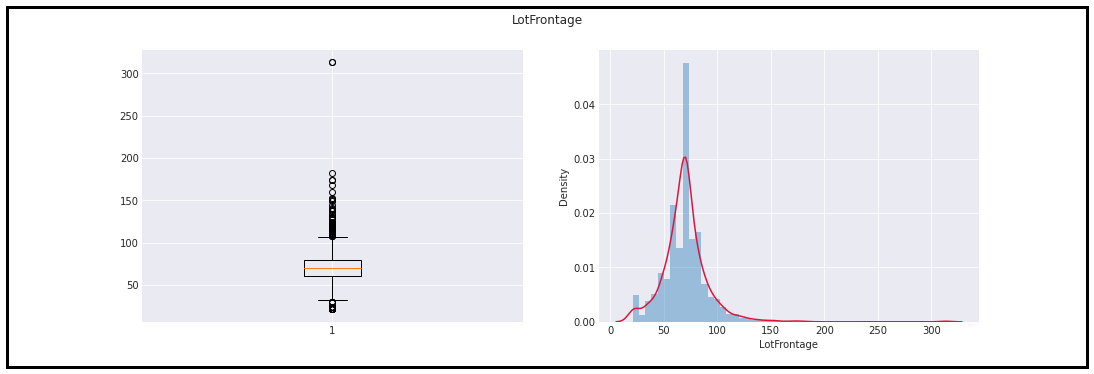

In [18]:
plot_hist_box(df_train.LotFrontage)

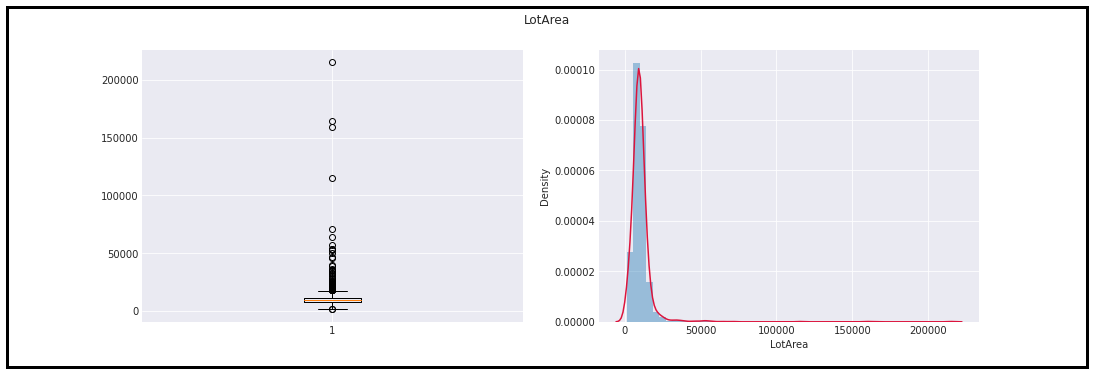

In [19]:
plot_hist_box(df_train.LotArea)

**Insight**
- LotArea is highly right-tailed
- LotFrontage after the imputation is slightly near to normal, but still we can see some tail
- We can check for outlier-percentage in both

In [20]:
# MSSubClass is a categorical variable as given in data description We can have a one hot encoding

# we have addition {150} in the df_test.MSSubClass label so directly one-hot encoding will not give 
# correct shape

train_MS_label = set(df_train.MSSubClass.value_counts().index.tolist())
test_MS_label = set(df_test.MSSubClass.value_counts().index.tolist())

print(f"Additional data in test is {test_MS_label-train_MS_label}")

# After getting dummy we have to concate additional column with zero filled 

df_train = pd.get_dummies(df_train,columns=['MSSubClass'])
df_test = pd.get_dummies(df_test,columns=['MSSubClass'])

# Concate Addition {150} column
df_t_0_l = [0]*df_train.shape[0]
df_0 = pd.DataFrame(df_t_0_l,columns=['MSSubClass_150'])
df_train = df_train.join(df_0)

Additional data in test is {150}


In [21]:
df_train.columns[df_train.dtypes != 'O']

Index(['LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SalePrice',
       'House_Age', 'RemodAge', 'Overall_Rating', 'LotFrontage',
       'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75',
       'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120',
       'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_150'],
      dtype='object')

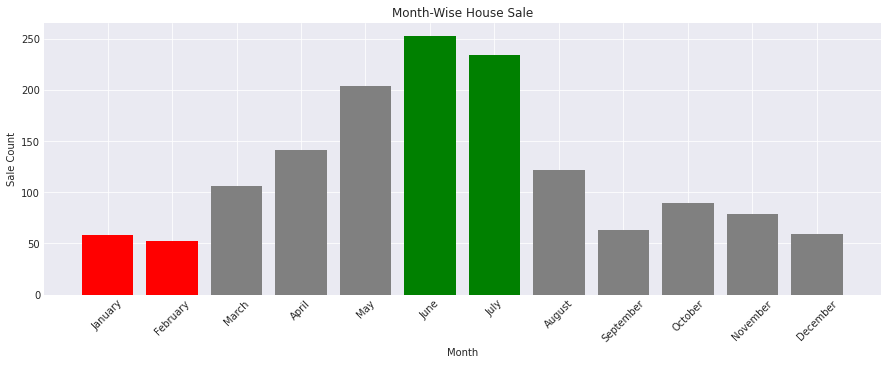

In [22]:
# Checking Highest sale by the Month of Sold
from calendar import month_name
from collections import OrderedDict

x = lambda x : datetime.date(1900, x, 1).strftime('%B')
month = list(map(x,df_train.MoSold.value_counts().index.to_list()))
sale_count = df_train.MoSold.value_counts().to_list()
month_sale = dict(zip(month,sale_count))
monthj = list(month_name)
monthj.remove('')
month_sale = OrderedDict([(a, month_sale[a]) for a in monthj])
plt.figure(figsize=(15,5))
colors = ['r','r','gray','gray','gray','g','g','gray','gray','gray','gray','gray']
plt.bar(month_sale.keys(),month_sale.values(),color=colors)
plt.title('Month-Wise House Sale')
plt.ylabel('Sale Count')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

**Insights**

- We can see that that all the month are not comman for sale, we have highest sale during the summer.
- Lowest sale in the month of Jan and Feb

In [23]:
# Since MoSold is a categorical variable so we have to have one hot encoding,we can drop the first value
df_train = pd.get_dummies(df_train,columns=['MoSold'],drop_first=True)
df_test = pd.get_dummies(df_test,columns=['MoSold'],drop_first=True)

In [24]:
df_train = pd.get_dummies(df_train,columns=['SaleCondition'],drop_first=True)
df_test = pd.get_dummies(df_test,columns=['SaleCondition'],drop_first=True)

In [25]:
# Exterior Quality and Exterior condition check the material on the  exterior side, we will be merging both the rating
label = {'None':0,'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1}
df_train.ExterQual.fillna('None',inplace=True)
df_test.ExterQual.fillna('None',inplace=True)
df_train.replace({'ExterQual':label},inplace=True)
df_test.replace({'ExterQual':label},inplace=True)

df_train.ExterCond.fillna('None',inplace=True)
df_test.ExterCond.fillna('None',inplace=True)
df_train.replace({'ExterCond':label},inplace=True)
df_test.replace({'ExterCond':label},inplace=True)

df_train['External_QC'] = (df_train.ExterCond + df_train.ExterQual)*0.5
df_test['External_QC'] = (df_test.ExterCond + df_test.ExterQual)*0.5

df_train.drop(labels=['ExterQual','ExterCond'],inplace=True,axis=1)
df_test.drop(labels=['ExterQual','ExterCond'],inplace=True,axis=1)

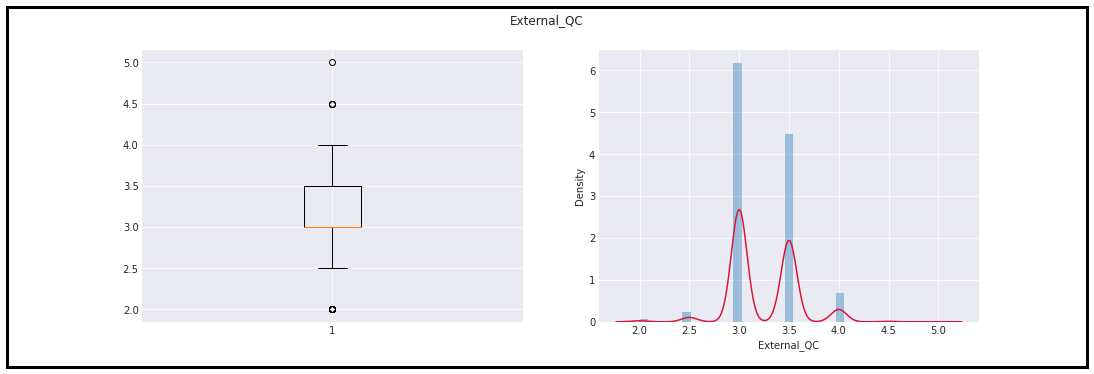

In [26]:
plot_hist_box(df_train.External_QC)

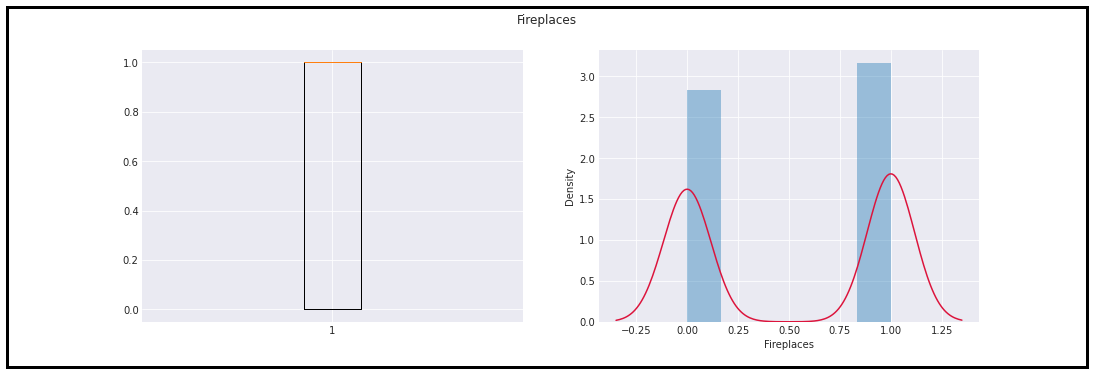

In [27]:
# Let's look at the Fireplaces count in houses, we will be converting to bimodular , either fireplace there or not
df_train.Fireplaces = (df_train.Fireplaces>0).astype(int)
plot_hist_box(df_train.Fireplaces)

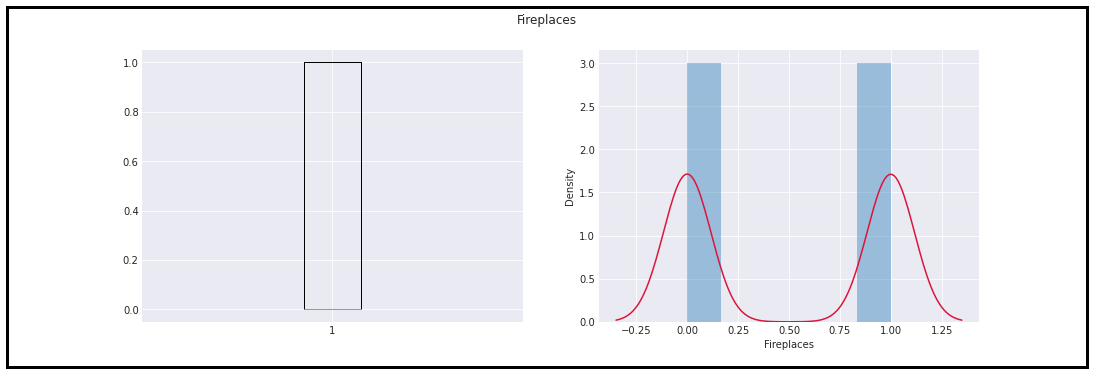

In [28]:
df_test.Fireplaces = (df_test.Fireplaces>0).astype(int)
plot_hist_box(df_test.Fireplaces)

In [29]:
# Encoding the Steet with 0 and 1
df_train['Street'].replace(['Pave','Grvl'],[0,1],inplace=True)
df_test['Street'].replace(['Pave','Grvl'],[0,1],inplace=True)

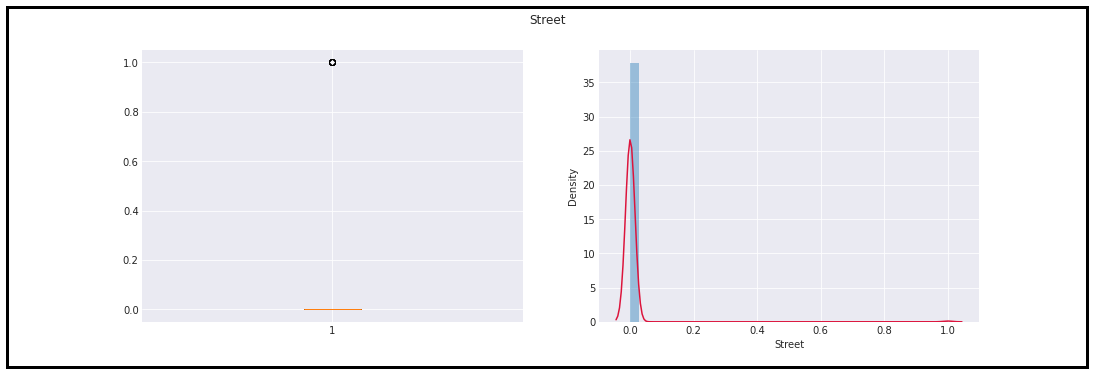

In [30]:
plot_hist_box(df_train.Street)

**Insight**
- We have unbalanced sample for Street Variable, let's perform a bivariate of Street with Sale Price

In [31]:
dum_var = ['LotShape','LandContour','LandSlope','LotConfig','Neighborhood','RoofStyle','PavedDrive','Foundation']

In [32]:
# Creating dummy variable for dum_var
df_train = pd.get_dummies(df_train,columns=dum_var,drop_first=True)
df_test = pd.get_dummies(df_test,columns=dum_var,drop_first=True)

In [33]:
# Encoding Heating Quality
label = {'None':0,'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1}
df_train.HeatingQC.fillna('None',inplace=True)
df_test.HeatingQC.fillna('None',inplace=True)
df_train.replace({'HeatingQC':label},inplace=True)
df_test.replace({'HeatingQC':label},inplace=True)

In [34]:
drop_obj = df_train.columns[df_train.dtypes == 'O'].to_list()
df_train.drop(labels=drop_obj,inplace=True,axis=1)
df_test.drop(labels=drop_obj,inplace=True,axis=1)

In [35]:
df_train.fillna(0,inplace=True)

In [36]:
df_train['Fence'] = train.Fence
df_test['Fence'] = test.Fence

df_train.fillna(0,inplace=True)
df_test.fillna(0,inplace=True)

In [37]:
# Checking if fence is available or not
df_train.Fence = (df_train.Fence!=0).astype(int)
df_test.Fence = (df_test.Fence!=0).astype(int)

# Model Preparation

In [38]:
X = df_train.drop('SalePrice',axis=1)
y = df_train[['SalePrice']]

print(X.shape)
print(y.shape)

(1460, 106)
(1460, 1)


In [39]:
# Spliting the data into test and train sample in 20:80 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data:{}".format(X_train.shape[0]))
print("Testing Data:{}".format(X_test.shape[0]))

Training Data:1168
Testing Data:292


## Linear Regression Model

In [40]:
Linear_Model = LinearRegression()
Linear_Model.fit(X_train,y_train)

LinearRegression()

In [41]:
pred = Linear_Model.predict(X_test) #Prediction on test data  
pred_train = Linear_Model.predict(X_train) # prediction on train data

In [42]:
# Mean Absolute Error
print(f"Mean absolute error of test data is {mean_absolute_error(y_test, pred)}")
print(f"Mean absolute error of train data is {mean_absolute_error(y_train, pred_train)}")
# RMSE
print(f"RMSE of test data is {mean_squared_error(y_test, pred , squared=False)}")
print(f"RMSE of train data is {mean_squared_error(y_train, pred_train,squared=False)}")
# R^2
print(f"R^2 of test data is {r2_score(y_test, pred)}")
print(f"R^2 of train data is {r2_score(y_train, pred_train)}")

Mean absolute error of test data is 21639.850997018642
Mean absolute error of train data is 19080.883805441477
RMSE of test data is 35464.42921912215
RMSE of train data is 29835.02902176458
R^2 of test data is 0.8360270859589217
R^2 of train data is 0.85076344400602


## Let's check the predicted value distribution

In [43]:
res_df = pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': pred.flatten()})
res_df['residual'] = res_df['Actual'] - res_df['Predicted']
res_df.head()

,Actual,Predicted,residual
0,154500,155578.140765,-1078.140765
1,325000,323619.670004,1380.329996
2,115000,108273.991990,6726.008010
3,159000,171914.140918,-12914.140918
4,315500,277753.888370,37746.111630


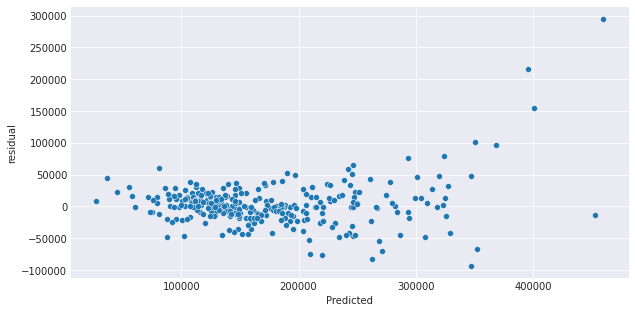

In [44]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=res_df['Predicted'],y=res_df['residual'])
plt.show()

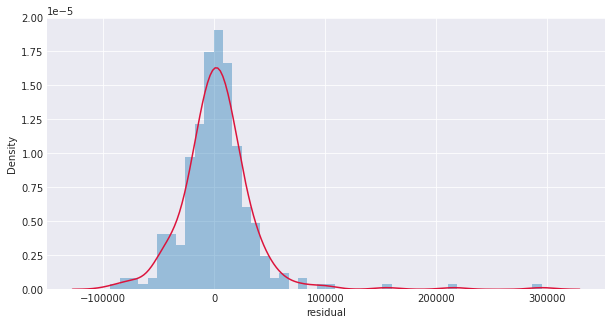

In [45]:
plt.figure(figsize=(10,5))
ax = sns.distplot(res_df['residual'])
ax.lines[0].set_color('crimson')
plt.show()

# Submission

In [46]:
predict = Linear_Model.predict(df_test)
ts = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.DataFrame()
submission['Id'] = ts.Id
submission['SalePrice'] = predict
submission.to_csv('submission.csv', index=False)

In [47]:
submission.sample(6)

,Id,SalePrice
509,1970,348816.393774
671,2132,113646.151399
553,2014,178716.495872
518,1979,314979.576862
660,2121,91059.217531
789,2250,120346.524817
